In [4]:
import os
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

from sionna.channel import utils

In [5]:
import tensorflow as tf
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

In [6]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sionna.channel import utils
from sionna.utils import QAMSource
from sionna.signal import Upsampling, Downsampling, RootRaisedCosineFilter, empirical_psd, empirical_aclr, RaisedCosineFilter

In [7]:
beta = 0.22 # Roll-off factor
span_in_symbols = 32 # Filter span in symbold
samples_per_symbol = 4 # Number of samples per symbol, i.e., the oversampling factor
rcf = RaisedCosineFilter(span_in_symbols, samples_per_symbol, beta)

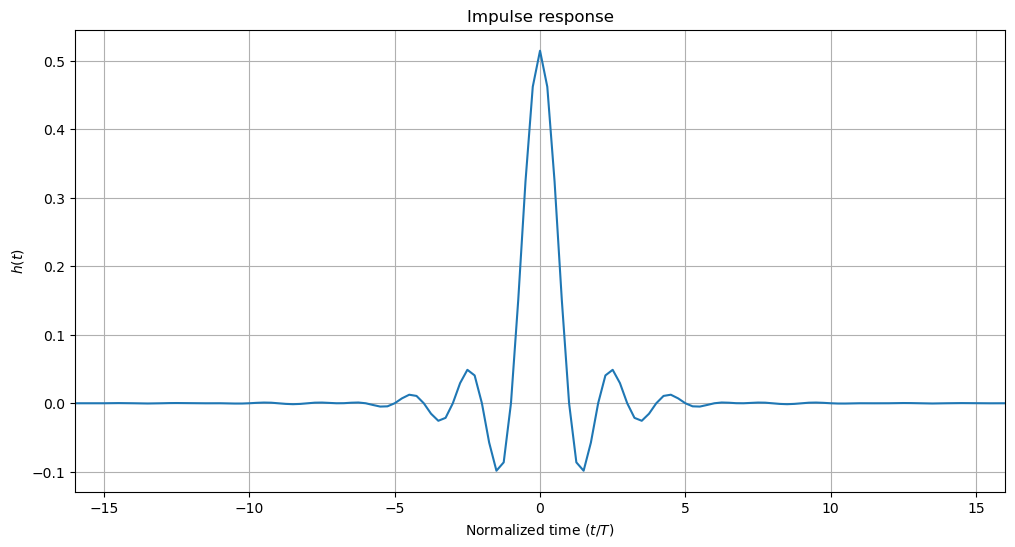

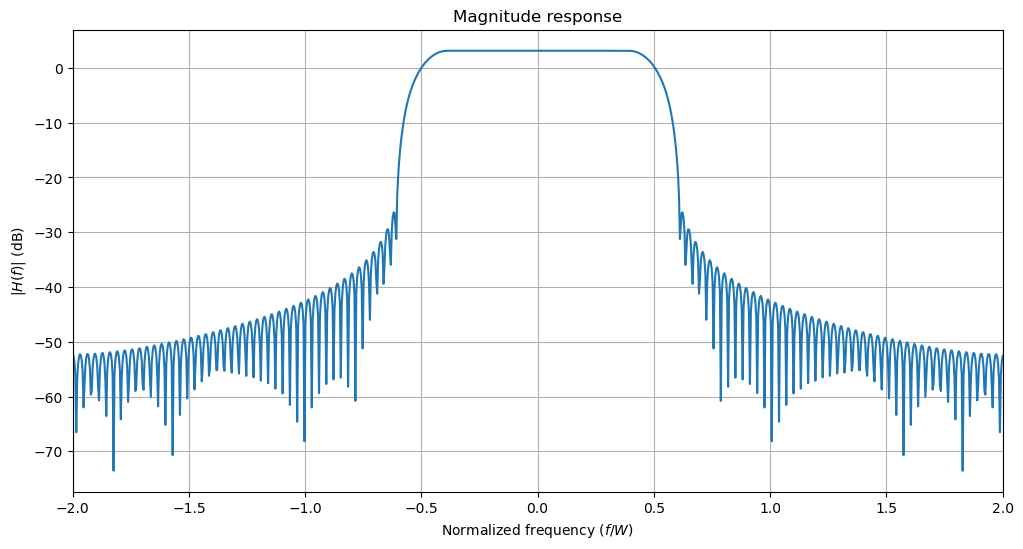

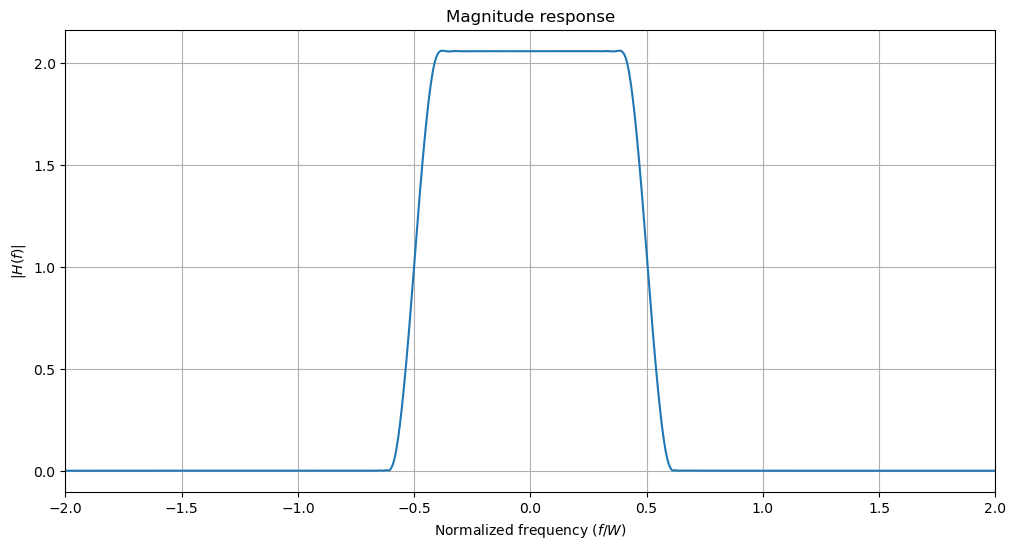

In [8]:
rcf.show("impulse")
rcf.show("magnitude", "db") # Logarithmic scale
rcf.show("magnitude", "lin") # Linear scale

In [9]:
print("Filter length:", rcf.length)

Filter length: 129


Shape of x (128, 1000)
Shape of x_us (128, 4000)


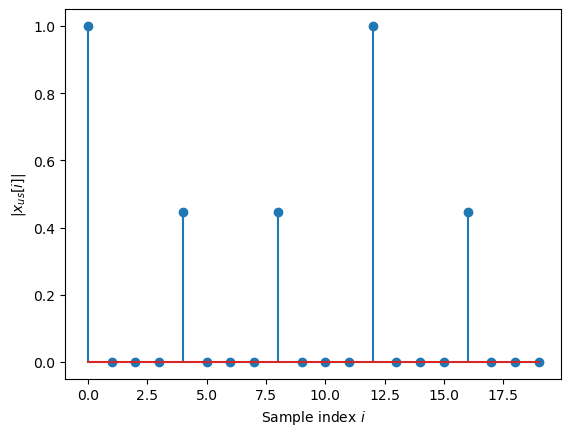

In [10]:
# Configure QAM source
num_bits_per_symbol = 4 # The modulation order of the QAM constellation, i.e., 16QAM
qam = QAMSource(num_bits_per_symbol) # Layer to generate batches of QAM symbols

# Generate batch of QAM symbol sequences
batch_size = 128
num_symbols = 1000
x = qam([batch_size, num_symbols])
print("Shape of x", x.shape)

# Create instance of the Upsampling layer
us = Upsampling(samples_per_symbol)

# Upsample the QAM symbol sequence
x_us = us(x)
print("Shape of x_us", x_us.shape)

# Inspect the first few elements of one row of x_us
plt.stem(np.abs(x_us)[0,:20]);
plt.xlabel(r"Sample index $i$")
plt.ylabel(r"|$x_{us}[i]$|");

In [11]:
# Filter the upsampled sequence
x_rcf = rcf(x_us)

In [12]:
x_rcf

<tf.Tensor: shape=(128, 4128), dtype=complex64, numpy=
array([[ 2.4594472e-20+8.1981580e-21j, -1.6272135e-05-5.4240459e-06j,
        -6.1426319e-05-2.0475441e-05j, ...,
         0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j,
         0.0000000e+00+0.0000000e+00j],
       [-8.1981580e-21-8.1981580e-21j,  5.4240459e-06+5.4240459e-06j,
         2.0475441e-05+2.0475441e-05j, ...,
         0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j,
         0.0000000e+00+0.0000000e+00j],
       [ 8.1981580e-21+2.4594472e-20j, -5.4240459e-06-1.6272135e-05j,
        -2.0475441e-05-6.1426319e-05j, ...,
         0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j,
         0.0000000e+00+0.0000000e+00j],
       ...,
       [-8.1981580e-21+8.1981580e-21j,  5.4240459e-06-5.4240459e-06j,
         2.0475441e-05-2.0475441e-05j, ...,
         0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j,
         0.0000000e+00+0.0000000e+00j],
       [ 8.1981580e-21-8.1981580e-21j

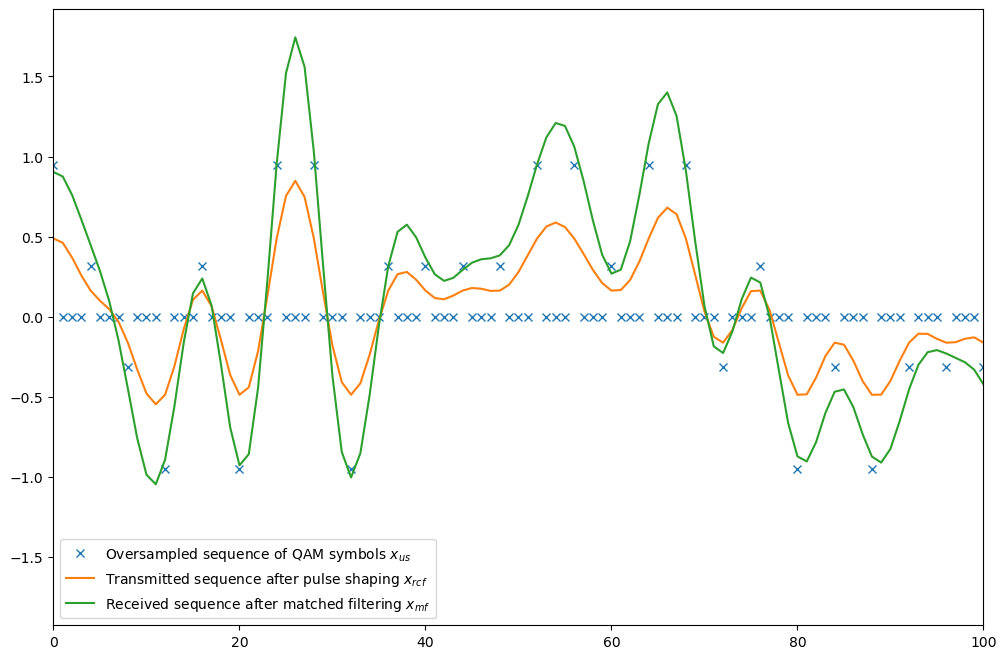

In [14]:
# Apply the matched filter
x_mf = rcf(x_rcf)

# Instantiate a downsampling layer
ds = Downsampling(samples_per_symbol, rcf.length-1, num_symbols)

# Recover the transmitted symbol sequence
x_hat = ds(x_mf)

# Visualize the different signals
plt.figure(figsize=(12, 8))
plt.plot(np.real(x_us[0]), "x")
plt.plot(np.real(x_rcf[0, rcf.length//2:]))
plt.plot(np.real(x_mf[0, rcf.length-1:]));
plt.xlim(0,100)
plt.legend([r"Oversampled sequence of QAM symbols $x_{us}$",
            r"Transmitted sequence after pulse shaping $x_{rcf}$",
            r"Received sequence after matched filtering $x_{mf}$"]);

In [17]:
# Simulation parameters
dtype = tf.complex128  # Simulation accuracy (double)
t_sim = int(1e4)  # (ps) Simulation time window
n_sim = int(1e4)  # Number of simulation samples

# Channel parameters
n_span = 3

# Impulse parameters
p_0 = 3e-2  # (W) Peak power of the Gaussian pulse
t_0 = 50  # (ps) Norm. temporal scaling of the Gaussian pulse

# Support
dt = t_sim / n_sim  # (s) sample duration
t, f = utils.time_frequency_vector(
    n_sim, dt, dtype=dtype.real_dtype)  # (ps), (THz) Time and frequency vector

# Generate Gaussian impulse
g_0 = np.sqrt(p_0 * 2**(-((2.0*t / t_0) ** 2.0)))
g_0 = tf.cast(g_0, dtype=dtype)
G_0 = tf.signal.fftshift(
        tf.abs(
            tf.cast(dt, dtype) *
            tf.signal.fft(g_0) /
            tf.cast(tf.math.sqrt(2 * np.pi), dtype)
        ) ** 2
)

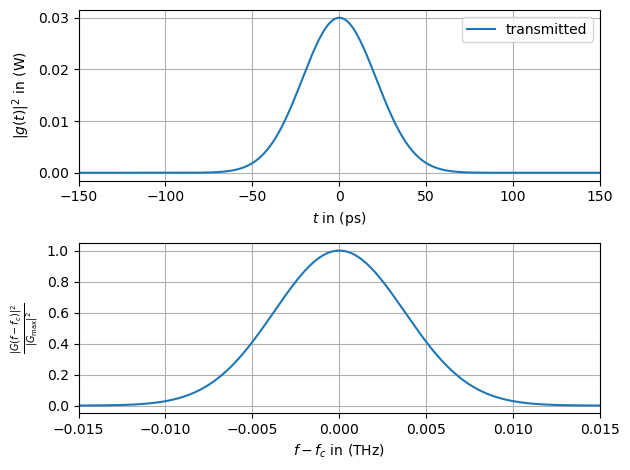

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(t.numpy().flatten(), np.abs(g_0.numpy().flatten())**2, '-')
ax1.set_xlim(-150, 150)
ax1.set_xlabel(r"$t$ in (ps)")
ax1.set_ylabel(r"$|g(t)|^2$ in (W)")
ax1.grid()

ax2.plot(
    f.numpy().flatten(),
    (G_0.numpy().flatten())/np.max(G_0.numpy().flatten()),
    '-')
ax2.set_xlim(-0.015, 0.015)
ax2.set_xlabel(r"$f-f_c$ in (THz)")
ax2.set_ylabel(r"$\frac{|G(f-f_c)|^2}{|G_\mathrm{max}|^2}$")
ax2.grid()

ax1.legend(['transmitted'])
plt.tight_layout()
plt.show()

In [19]:
# Normalization
t_norm = 1e-12  # (s) -> (ps) Time normalization
z_norm = 1e3  # (m) -> (km) Distance normalization

# Fiber parameters
f_c = 193.55e12  # (Hz) Abs. Carrier frequency
length_sp = 80.0  # (km) Norm. fiber span length
alpha = 0.046  # (1/km) Norm. fiber attenuation

# EDFA parameters
g_edfa = tf.exp(alpha * length_sp)
f_edfa = 10**(5/10)  # (1) Noise figure

In [20]:
beta_2 = -21.67  # (ps^2/km) Norm. group velocity dispersion

In [21]:
span = sionna.channel.optical.SSFM(
            alpha=alpha,
            beta_2=beta_2,
            f_c=f_c,
            length=length_sp,
            sample_duration=dt,
            with_amplification=False,
            with_attenuation=False,
            with_dispersion=True,
            with_nonlinearity=False,
            dtype=dtype,
            t_norm=t_norm)

amplifier = sionna.channel.optical.EDFA(
            g=g_edfa,
            f=0,
            f_c=f_c,
            dt=samples_per_symbol,#dt * t_norm,  # t_norm is in absolute (not normalized) units
            dtype=dtype)

def lumped_amplification_channel(inputs):
    (u_0) = inputs

    u = u_0
    for _ in range(n_span):
        u = span(u)
        u = amplifier(u)

    return u

In [26]:
g_0

<tf.Tensor: shape=(10000,), dtype=complex128, numpy=array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])>

In [23]:
x

<tf.Tensor: shape=(128, 1000), dtype=complex64, numpy=
array([[ 0.9486833+0.3162278j,  0.3162278+0.3162278j,
        -0.3162278+0.3162278j, ..., -0.3162278-0.3162278j,
        -0.3162278-0.9486833j,  0.3162278+0.3162278j],
       [-0.3162278-0.3162278j,  0.3162278+0.3162278j,
        -0.9486833+0.9486833j, ...,  0.9486833+0.3162278j,
        -0.9486833+0.3162278j,  0.3162278-0.3162278j],
       [ 0.3162278+0.9486833j, -0.9486833-0.9486833j,
        -0.3162278-0.3162278j, ...,  0.9486833+0.9486833j,
        -0.3162278+0.3162278j, -0.9486833-0.9486833j],
       ...,
       [-0.3162278+0.3162278j, -0.9486833+0.9486833j,
        -0.9486833-0.9486833j, ..., -0.3162278+0.3162278j,
         0.3162278-0.3162278j,  0.3162278-0.9486833j],
       [ 0.3162278-0.3162278j, -0.9486833-0.3162278j,
         0.9486833-0.9486833j, ..., -0.3162278+0.3162278j,
        -0.9486833-0.9486833j,  0.3162278+0.3162278j],
       [ 0.3162278+0.9486833j,  0.9486833-0.9486833j,
         0.9486833+0.3162278j, ...,  0.

In [27]:
x = g_0
# x = x_rcf
# x = tf.cast(x, dtype=dtype)
y = lumped_amplification_channel(x)

X = tf.signal.fftshift(
    tf.abs(
        tf.cast(samples_per_symbol, dtype) *
        tf.signal.fft(x) /
        tf.cast(tf.math.sqrt(2 * np.pi), dtype)
    ) ** 2
)

Y = tf.signal.fftshift(
    tf.abs(
        tf.cast(samples_per_symbol, dtype) *
        tf.signal.fft(y) /
        tf.cast(tf.math.sqrt(2 * np.pi), dtype)
    ) ** 2
)

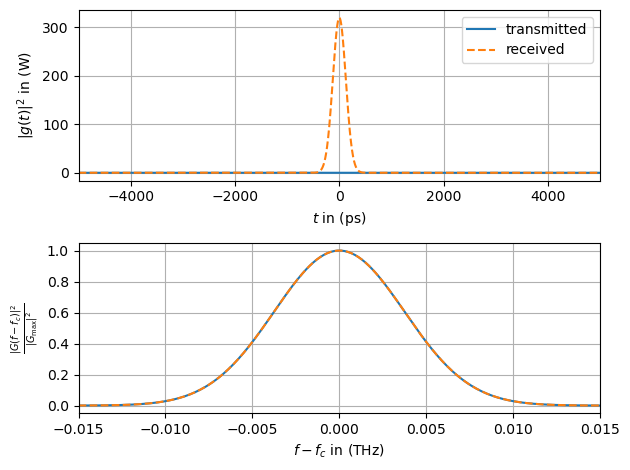

In [28]:
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(t.numpy().flatten(), np.abs(x.numpy().flatten())**2, '-')
ax1.plot(t.numpy().flatten(), np.abs(y.numpy().flatten())**2, '--')
ax1.set_xlim(-5000, 5000)
ax1.set_xlabel(r"$t$ in (ps)")
ax1.set_ylabel(r"$|g(t)|^2$ in (W)")
ax1.grid()

ax2.plot(
    f.numpy().flatten(),
    (X.numpy().flatten())/np.max(X.numpy().flatten()),
    '-')
ax2.plot(
    f.numpy().flatten(),
    (Y.numpy().flatten())/np.max(Y.numpy().flatten()),
    '--')
ax2.set_xlim(-0.015, 0.015)
ax2.set_xlabel(r"$f-f_c$ in (THz)")
ax2.set_ylabel(r"$\frac{|G(f-f_c)|^2}{|G_\mathrm{max}|^2}$")
ax2.grid()

ax1.legend(['transmitted', 'received'])
plt.tight_layout()

plt.show()